In [14]:
from datetime import datetime
import math
import cv2
import glob
import numpy as np
from numpy import zeros, ones, vstack, hstack
from numpy.random import permutation
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
from sklearn.utils import shuffle
from skimage.metrics import structural_similarity as ssim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/puneet6060/intel-image-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  fratzcan


Your Kaggle Key:

  ········


Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification


100%|██████████| 346M/346M [00:00<00:00, 1.24GB/s]


In [3]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [4]:
import wandb

wandb.login(key = '4d975cec314dd2bfa52914355589e22b23c1fc6e')

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: firatozc (firatozc-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [5]:
def RGB2LAB2(R0, G0, B0):
    R = R0 / 255
    G = G0 / 255
    B = B0 / 255

    Y = 0.299*R + 0.587*G + 0.114*B
    X = 0.449*R + 0.353*G + 0.198*B
    Z = 0.012*R + 0.089*G + 0.899*B

    L = Y
    a = (X - Y) / 0.234
    b = (Y - Z) / 0.785

    return L, a, b


def LAB22RGB(L, a, b):
    a11 = 0.299
    a12 = 0.587
    a13 = 0.114
    a21 = (0.15/0.234)
    a22 = (-0.234/0.234)
    a23 = (0.084/0.234)
    a31 = (0.287/0.785)
    a32 = (0.498/0.785)
    a33 = (-0.785/0.785)

    aa = np.array([[a11, a12, a13], [a21, a22, a23], [a31, a32, a33]])
    C0 = np.zeros((L.shape[0], 3))
    C0[:, 0] = L[:, 0]
    C0[:, 1] = a[:, 0]
    C0[:, 2] = b[:, 0]
    C = np.transpose(C0)

    X = np.linalg.inv(aa).dot(C)
    X1D = np.reshape(X, (X.shape[0]*X.shape[1], 1))
    p0 = np.where(X1D < 0)
    X1D[p0[0]] = 0
    p1 = np.where(X1D > 1)
    X1D[p1[0]] = 1
    Xr = np.reshape(X1D, (X.shape[0], X.shape[1]))

    Rr = Xr[0][:]
    Gr = Xr[1][:]
    Br = Xr[2][:]

    R = np.uint8(np.round(Rr * 255))
    G = np.uint8(np.round(Gr * 255))
    B = np.uint8(np.round(Br * 255))
    return R, G, B

In [6]:
def psnr(img1, img2):
    mse = np.mean((img1.astype("float") - img2.astype("float")) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

def mse(imageA, imageB, bands):
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1] * bands)
    return err

def mae(imageA, imageB, bands):
    err = np.sum(np.abs((imageA.astype("float") - imageB.astype("float"))))
    err /= float(imageA.shape[0] * imageA.shape[1] * bands)
    return err

def rmse(imageA, imageB, bands):
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1] * bands)
    err = np.sqrt(err)
    return err

In [7]:
class DoubleConv(nn.Module):
    """Double Convolution Block"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [8]:
class TripleConv(nn.Module):
    """Triple Convolution Block"""
    def __init__(self, in_channels, out_channels):
        super(TripleConv, self).__init__()
        self.triple_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.triple_conv(x)

In [9]:
class UNet1(nn.Module):
    def __init__(self, in_channels=1, out_channels=2):
        super(UNet1, self).__init__()

        # Encoder
        self.conv1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = TripleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.conv4 = TripleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.conv5 = TripleConv(512, 512)
        self.pool5 = nn.MaxPool2d(2)

        # Bottleneck
        self.conv55 = TripleConv(512, 512)

        # Decoder
        self.up66 = nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2)
        self.conv66 = DoubleConv(1024, 512)  # 512 + 512 from skip connection

        self.up6 = nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2)
        self.conv6 = DoubleConv(1024, 512)  # 512 + 512 from skip connection

        self.up7 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv7 = DoubleConv(512, 256)  # 256 + 256 from skip connection

        self.up8 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv8 = DoubleConv(256, 128)  # 128 + 128 from skip connection

        self.up9 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv9 = DoubleConv(128, 64)  # 64 + 64 from skip connection

        # Multi-scale feature fusion
        self.up_f02 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.up_f12 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        # Final layers
        self.conv11 = nn.Conv2d(384, 128, kernel_size=3, padding=1)  # 64+64+128+128
        self.relu11 = nn.ReLU(inplace=True)

        self.conv12 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.relu12 = nn.ReLU(inplace=True)

        self.conv13 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.relu13 = nn.ReLU(inplace=True)

        self.conv14 = nn.Conv2d(64, out_channels, kernel_size=3, padding=1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        # Encoder
        conv1 = self.conv1(x)
        x1 = self.pool1(conv1)

        conv2 = self.conv2(x1)
        x2 = self.pool2(conv2)

        conv3 = self.conv3(x2)
        x3 = self.pool3(conv3)

        conv4 = self.conv4(x3)
        x4 = self.pool4(conv4)

        conv5 = self.conv5(x4)
        x5 = self.pool5(conv5)

        # Bottleneck
        conv55 = self.conv55(x5)

        # Decoder
        up66 = self.up66(conv55)
        if up66.size()[2:] != conv5.size()[2:]:
            up66 = F.interpolate(up66, size=conv5.size()[2:], mode="bilinear", align_corners=True)
        merge66 = torch.cat([conv5, up66], dim=1)
        conv66 = self.conv66(merge66)

        up6 = self.up6(conv66)
        if up6.size()[2:] != conv4.size()[2:]:
            up6 = F.interpolate(up6, size=conv4.size()[2:], mode="bilinear", align_corners=True)
        merge6 = torch.cat([conv4, up6], dim=1)
        conv6 = self.conv6(merge6)

        up7 = self.up7(conv6)
        if up7.size()[2:] != conv3.size()[2:]:
            up7 = F.interpolate(up7, size=conv3.size()[2:], mode="bilinear", align_corners=True)
        merge7 = torch.cat([conv3, up7], dim=1)
        conv7 = self.conv7(merge7)

        up8 = self.up8(conv7)
        if up8.size()[2:] != conv2.size()[2:]:
            up8 = F.interpolate(up8, size=conv2.size()[2:], mode="bilinear", align_corners=True)
        merge8 = torch.cat([conv2, up8], dim=1)
        conv8 = self.conv8(merge8)

        up9 = self.up9(conv8)
        if up9.size()[2:] != conv1.size()[2:]:
            up9 = F.interpolate(up9, size=conv1.size()[2:], mode="bilinear", align_corners=True)
        merge9 = torch.cat([conv1, up9], dim=1)
        conv9 = self.conv9(merge9)


        # Multi-scale feature fusion
        up_f01 = conv1  # Original resolution
        up_f11 = conv9  # Decoded features
        up_f02 = self.up_f02(conv2)  # Upsampled encoder features
        up_f12 = self.up_f12(conv8)  # Upsampled decoder features

        # Concatenate multi-scale features
        merge11 = torch.cat([up_f01, up_f11, up_f02, up_f12], dim=1)

        # Final processing
        conv11 = self.relu11(self.conv11(merge11))
        conv12 = self.relu12(self.conv12(conv11))
        conv13 = self.relu13(self.conv13(conv12))
        output = self.tanh(self.conv14(conv13))

        return output

In [10]:
class ColorizationDataset(Dataset):
    def __init__(self, file_list, dim=150):
        self.file_list = file_list # image paths
        self.dim = dim

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        # Read image
        img_path = self.file_list[idx]
        img = cv2.imread(img_path)
        img = cv2.resize(img, (self.dim, self.dim))

        # Convert to LAB2
        sz0, sz1 = img.shape[:2]

        # R1 = img[:, :, 0].reshape(-1, 1)
        # G1 = img[:, :, 1].reshape(-1, 1)
        # B1 = img[:, :, 2].reshape(-1, 1)

        R1 = img[:, :, 2].reshape(-1, 1)
        G1 = img[:, :, 1].reshape(-1, 1)
        B1 = img[:, :, 0].reshape(-1, 1)

        L, A, B = RGB2LAB2(R1, G1, B1)

        L = L.reshape(sz0, sz1, 1)
        A = A.reshape(sz0, sz1)
        B = B.reshape(sz0, sz1)

        ab = np.stack([A, B], axis=2)

        # Convert to tensors and normalize
        L_tensor = torch.FloatTensor(L).permute(2, 0, 1)  # (1, H, W)
        ab_tensor = torch.FloatTensor(ab).permute(2, 0, 1)  # (2, H, W)

        return L_tensor, ab_tensor

In [11]:
def load_vgg16_weights(model):
    """Load pretrained VGG16 weights to U-Net encoder"""
    vgg16 = models.vgg16(pretrained=True).to(device)
    vgg_features = vgg16.features

    # Adapt first layer from RGB to grayscale
    with torch.no_grad():
        # Get original RGB weights
        rgb_weights = vgg_features[0].weight  # Shape: (64, 3, 3, 3)
        # Average across RGB channels
        gray_weights = rgb_weights.mean(dim=1, keepdim=True)  # Shape: (64, 1, 3, 3)

        # Set weights for first layer
        model.conv1.double_conv[0].weight.data = gray_weights
        model.conv1.double_conv[0].bias.data = vgg_features[0].bias.data

        # Set weights for second conv in first block
        model.conv1.double_conv[2].weight.data = vgg_features[2].weight.data
        model.conv1.double_conv[2].bias.data = vgg_features[2].bias.data

        # Second block
        model.conv2.double_conv[0].weight.data = vgg_features[5].weight.data
        model.conv2.double_conv[0].bias.data = vgg_features[5].bias.data
        model.conv2.double_conv[2].weight.data = vgg_features[7].weight.data
        model.conv2.double_conv[2].bias.data = vgg_features[7].bias.data

        # Third block (first two convs)
        model.conv3.triple_conv[0].weight.data = vgg_features[10].weight.data
        model.conv3.triple_conv[0].bias.data = vgg_features[10].bias.data
        model.conv3.triple_conv[2].weight.data = vgg_features[12].weight.data
        model.conv3.triple_conv[2].bias.data = vgg_features[12].bias.data
        model.conv3.triple_conv[4].weight.data = vgg_features[14].weight.data
        model.conv3.triple_conv[4].bias.data = vgg_features[14].bias.data

        # Fourth block
        model.conv4.triple_conv[0].weight.data = vgg_features[17].weight.data
        model.conv4.triple_conv[0].bias.data = vgg_features[17].bias.data
        model.conv4.triple_conv[2].weight.data = vgg_features[19].weight.data
        model.conv4.triple_conv[2].bias.data = vgg_features[19].bias.data
        model.conv4.triple_conv[4].weight.data = vgg_features[21].weight.data
        model.conv4.triple_conv[4].bias.data = vgg_features[21].bias.data

        # Fifth block
        model.conv5.triple_conv[0].weight.data = vgg_features[24].weight.data
        model.conv5.triple_conv[0].bias.data = vgg_features[24].bias.data
        model.conv5.triple_conv[2].weight.data = vgg_features[26].weight.data
        model.conv5.triple_conv[2].bias.data = vgg_features[26].bias.data
        model.conv5.triple_conv[4].weight.data = vgg_features[28].weight.data
        model.conv5.triple_conv[4].bias.data = vgg_features[28].bias.data

In [18]:
def train_model():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Parameters
    dim = 150
    batch_size = 16
    epochs_max = 40
    max_nb_min = 3

    cwd = os.getcwd()
    # train_path = os.path.join(cwd, 'seg_train', '*.png')
    # files_tr_list = glob.glob(train_path)

    # N = len(files_tr_list)
    # print(f'Number of training images: {N}')


    # base_path = "/content/intel-image-classification/seg_train/seg_train"
    base_path = "/kaggle/working/intel-image-classification/seg_train/seg_train"
    
    classes = os.listdir(base_path)

    image_paths = []

    for cls in classes:
        folder_path = os.path.join(base_path, cls, "*.jpg")
        for file in glob.glob(folder_path):
            image_paths.append(file)

    print("Number of training images:", len(image_paths))

    # Create model
    model = UNet1(in_channels=1, out_channels=2).to(device)

    # Load VGG16 pretrained weights
    print('Loading VGG16 pretrained weights...')
    load_vgg16_weights(model)

    # Loss function and optimizer
    criterion = nn.L1Loss()  # Mean Absolute Error
    optimizer = optim.Adam(model.parameters(), lr=5.6008593690527854e-05)


    wandb.init(project="image_colorization", name="HyperUNet_experiment-Intel-Image-MAE-40Epoch",
            config={
                "batch_size": batch_size,
                "epochs": epochs_max,
                "learning_rate": 5.6008593690527854e-05,
                "model_name": "HyperUNet-Intel-Image",
                "optimizer": "Adam",
                "loss_function": "L1Loss",
                "dataset": "Intel Image"
            })


    # Train/Val split
    train_paths, val_paths = train_test_split(image_paths, test_size=0.2, random_state=42)

    # Dataset ve dataloader
    dataset = ColorizationDataset(train_paths, dim=dim)
    val_dataset = ColorizationDataset(val_paths, dim=dim)

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    # dataset = ColorizationDataset(image_paths, dim=dim)
    # dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

    # Training tracking
    tr_acc = np.zeros((epochs_max, 2))
    time_tr = np.zeros((epochs_max, 2))
    mae_min = float('inf')
    nb_min = 0
    stop = 0

    print('Starting training...')

    train_losses = []
    val_losses = []

    for epoch in range(epochs_max):
        if stop:
            break

        start_time = datetime.now()
        model.train()

        total_loss = 0.0
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(dataloader)
        train_losses.append(avg_train_loss)

        # --- Validation Loss ---
        model.eval()
        val_loss_total = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                val_loss = criterion(outputs, targets)
                val_loss_total += val_loss.item()

        avg_val_loss = val_loss_total / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs_max}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")

        # Early stopping ve model kaydetme
        if avg_val_loss < mae_min:
            mae_min = avg_val_loss
            nb_min = 0
            torch.save(model.state_dict(), os.path.join(cwd, 'Hyper_U_NET_pytorch.pth'))
            print(f'New best model saved with val_loss: {mae_min:.6f}')
        else:
            nb_min += 1
            if nb_min > max_nb_min:
                stop = 1
                print('Early stopping triggered')

        # Plotting
        sns.set(style="whitegrid")
        
        plt.figure(figsize=(8,5))
        
        # Train loss
        plt.plot(train_losses, label="Train Loss", 
                 marker='o', markersize=5, markerfacecolor='white', 
                 linewidth=2, alpha=0.8)
        
        # Validation loss
        plt.plot(val_losses, label="Validation Loss", 
                 marker='s', markersize=5, markerfacecolor='white', 
                 linewidth=2, alpha=0.8)
        
        plt.xlabel("Epochs", fontsize=12)
        plt.ylabel("Loss", fontsize=12)
        plt.title("Train vs Validation Loss", fontsize=14, weight='bold')
        plt.legend(fontsize=10)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

        # Save progress
        np.save(os.path.join(cwd, 'tr_Acc_Hyper_U_NET_pytorch.npy'), tr_acc)
        np.save(os.path.join(cwd, 'Tr_runtime_Hyper_U_NET_pytorch.npy'), time_tr)


In [16]:
def load_model_for_inference(model_path, device):
    """Load trained model for inference"""
    model = UNet1(in_channels=1, out_channels=2).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

def inference(model, l_channel):
    """Perform inference on L channel to get ab channels"""
    model.eval()
    with torch.no_grad():
        if len(l_channel.shape) == 3:
            l_channel = l_channel.unsqueeze(0)  # Add batch dimension

        l_tensor = torch.FloatTensor(l_channel).to(device)
        ab_pred = model(l_tensor)

        return ab_pred.cpu().numpy()

Number of training images: 14034
Loading VGG16 pretrained weights...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 218MB/s]  


Starting training...
Epoch 1/40, Train Loss: 0.054980, Val Loss: 0.051703
New best model saved with val_loss: 0.051703


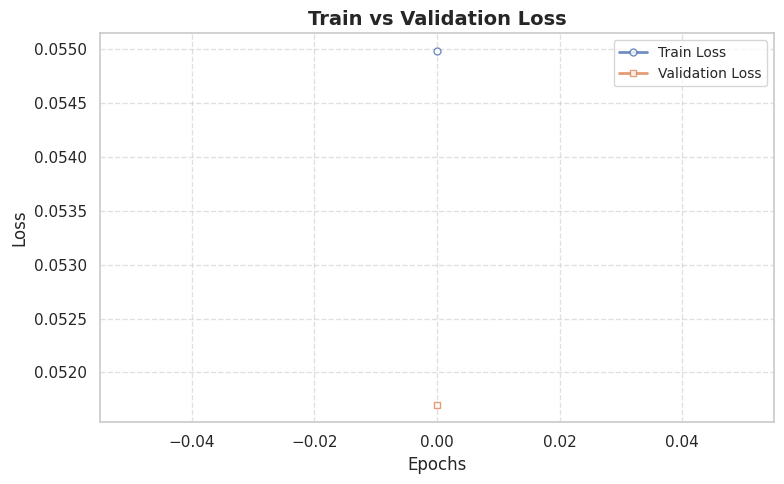

Epoch 2/40, Train Loss: 0.050333, Val Loss: 0.051197
New best model saved with val_loss: 0.051197


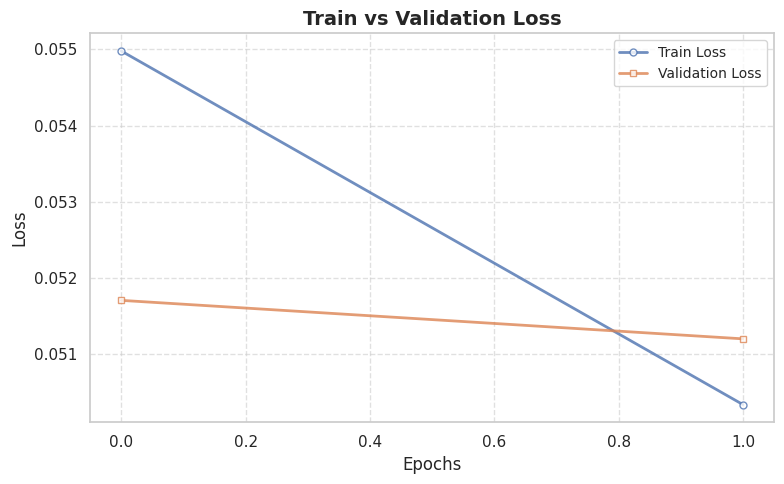

Epoch 3/40, Train Loss: 0.048362, Val Loss: 0.048809
New best model saved with val_loss: 0.048809


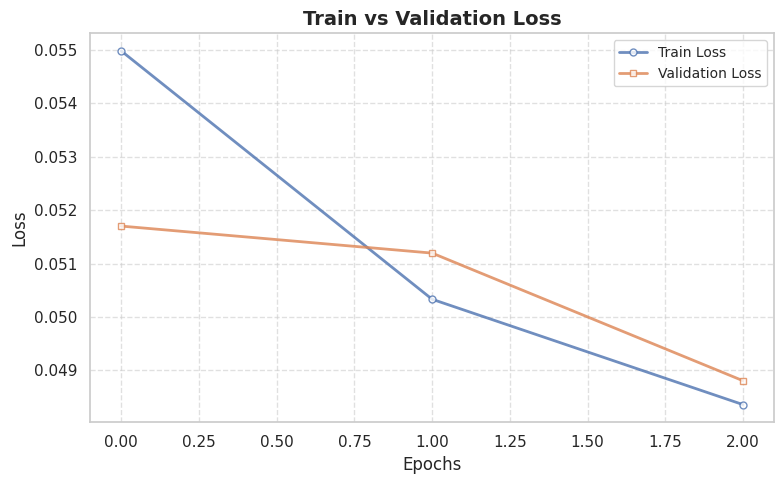

Epoch 4/40, Train Loss: 0.046863, Val Loss: 0.049579


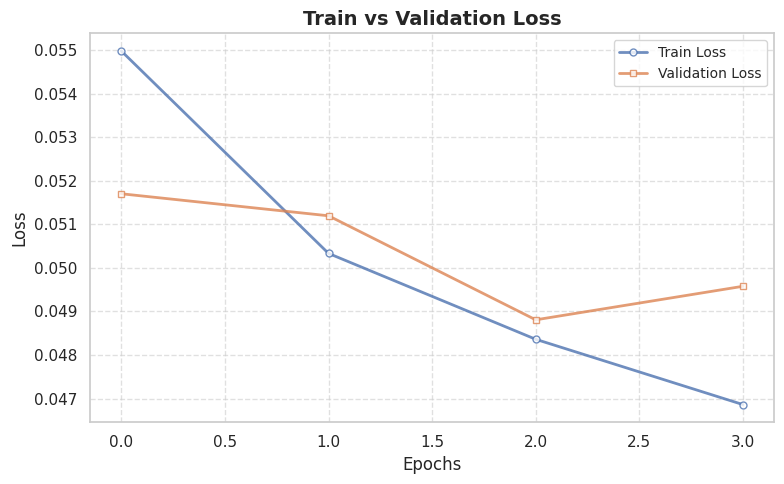

Epoch 5/40, Train Loss: 0.045579, Val Loss: 0.046972
New best model saved with val_loss: 0.046972


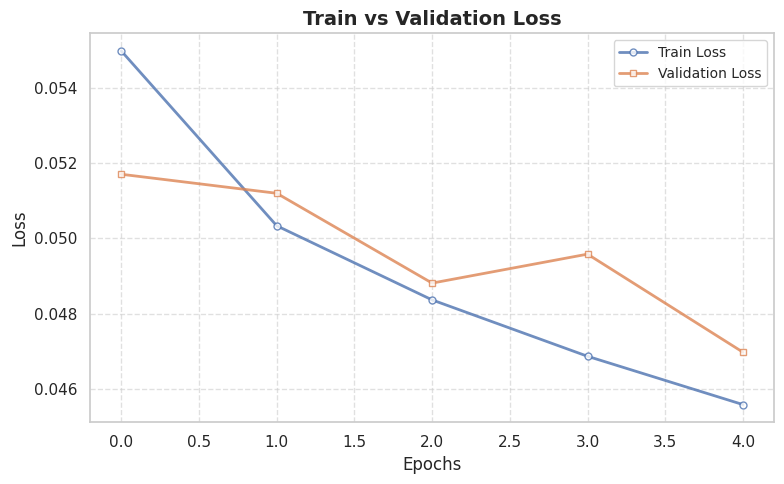

Epoch 6/40, Train Loss: 0.043490, Val Loss: 0.049912


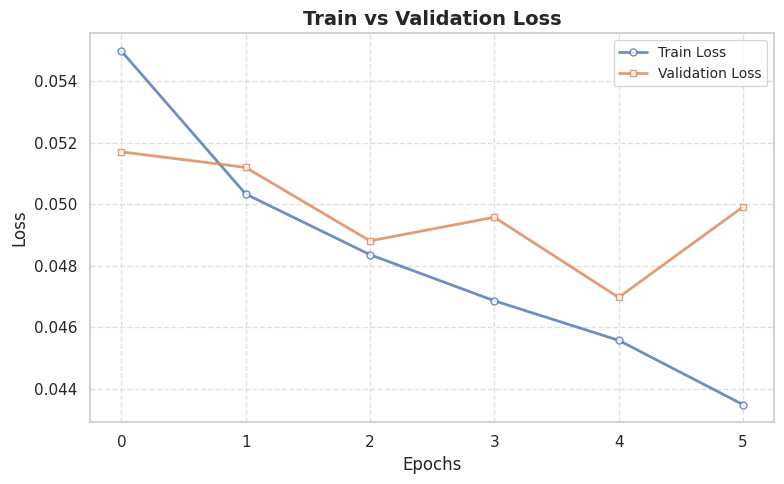

Epoch 7/40, Train Loss: 0.041821, Val Loss: 0.047148


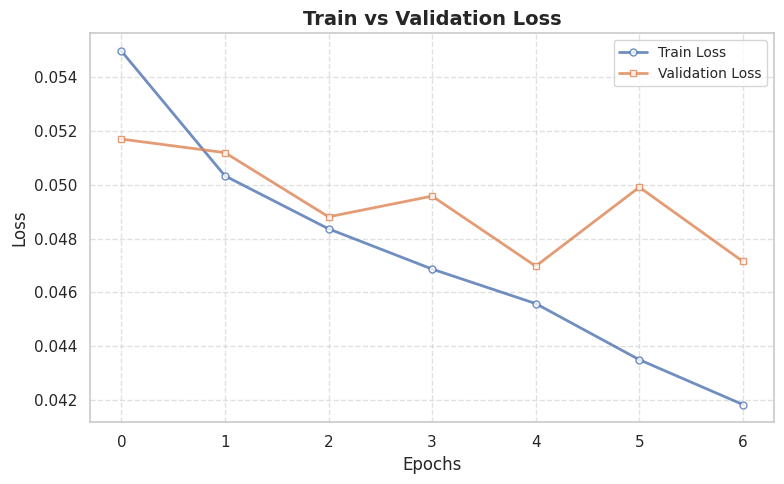

Epoch 8/40, Train Loss: 0.039937, Val Loss: 0.048808


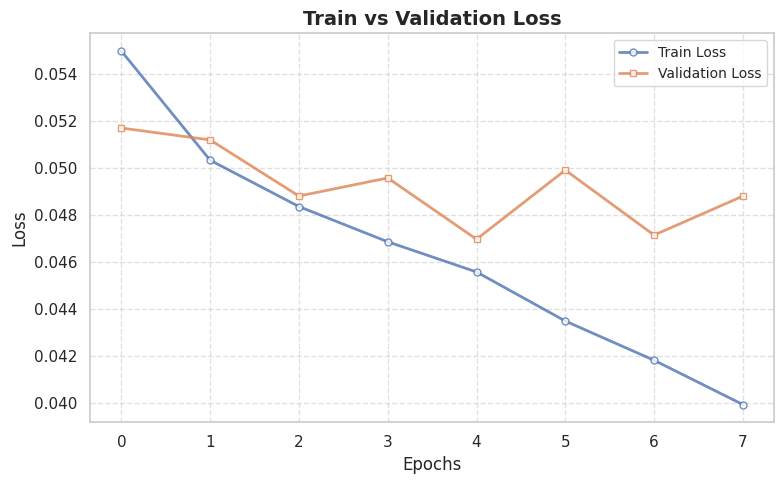

Epoch 9/40, Train Loss: 0.037963, Val Loss: 0.046880
New best model saved with val_loss: 0.046880


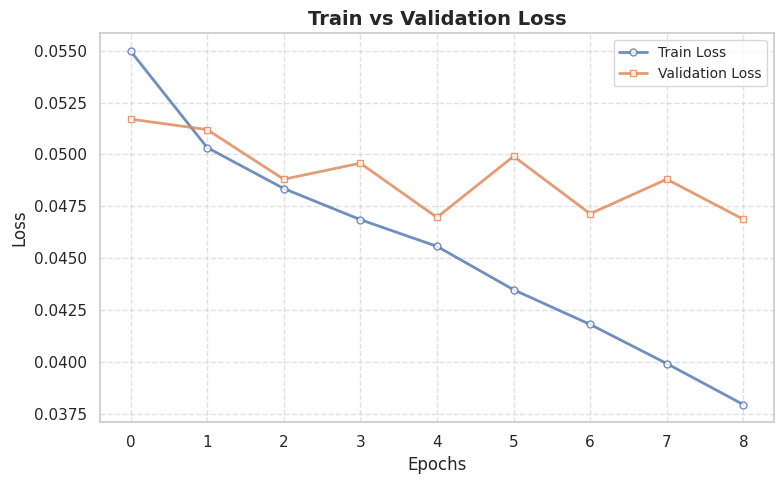

Epoch 10/40, Train Loss: 0.036200, Val Loss: 0.047339


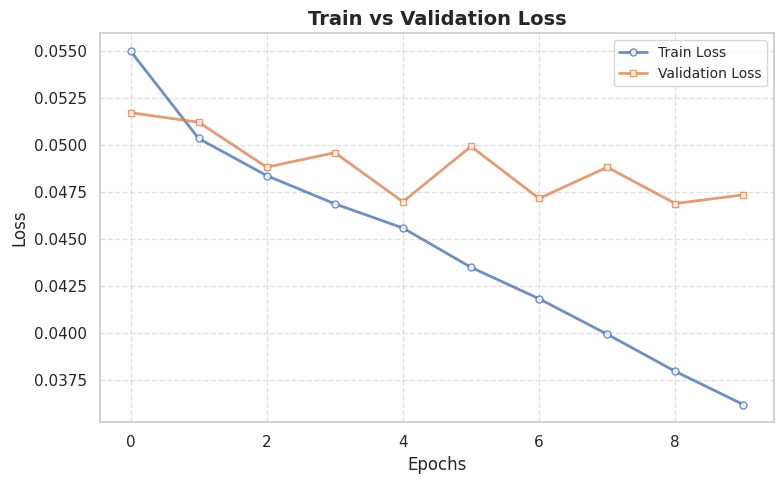

Epoch 11/40, Train Loss: 0.035005, Val Loss: 0.046787
New best model saved with val_loss: 0.046787


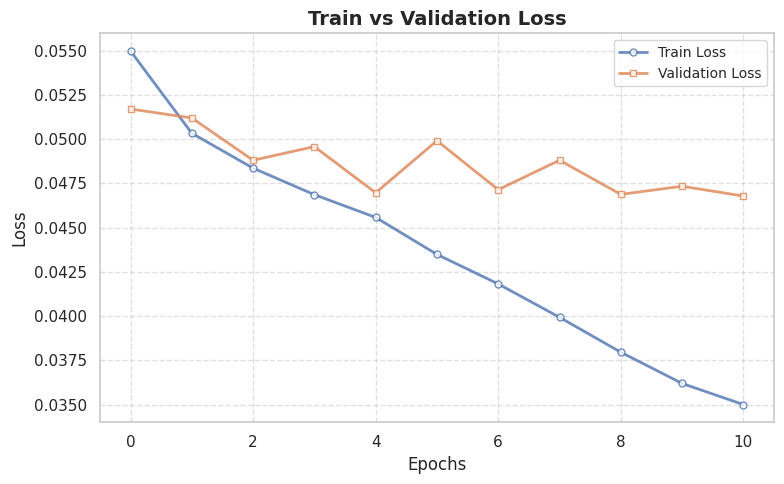

Epoch 12/40, Train Loss: 0.033758, Val Loss: 0.046796


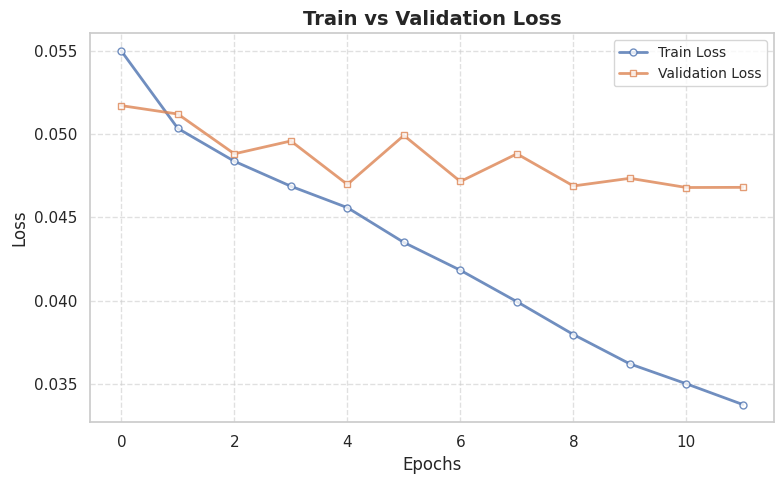

Epoch 13/40, Train Loss: 0.032815, Val Loss: 0.046608
New best model saved with val_loss: 0.046608


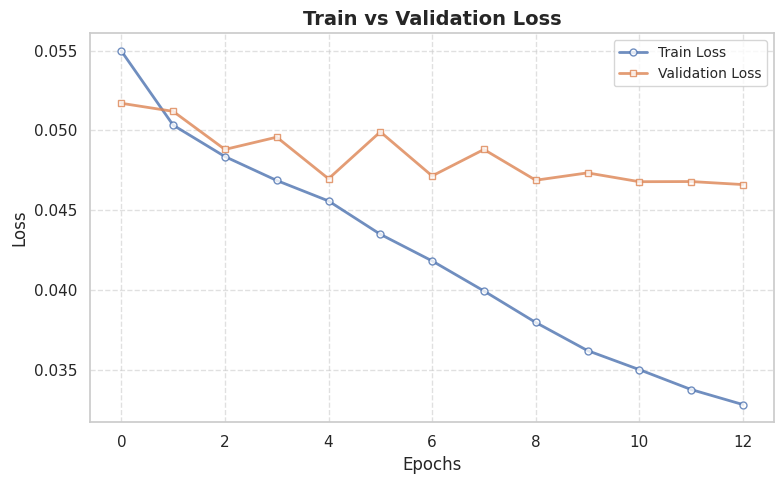

Epoch 14/40, Train Loss: 0.031979, Val Loss: 0.046300
New best model saved with val_loss: 0.046300


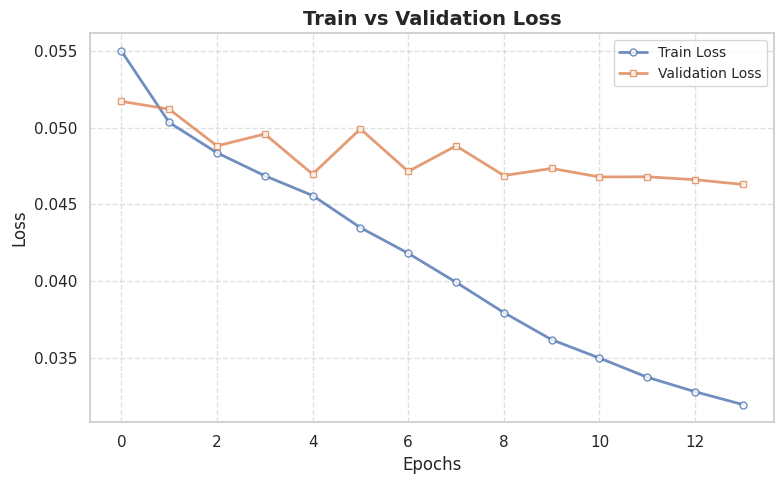

Epoch 15/40, Train Loss: 0.031168, Val Loss: 0.046687


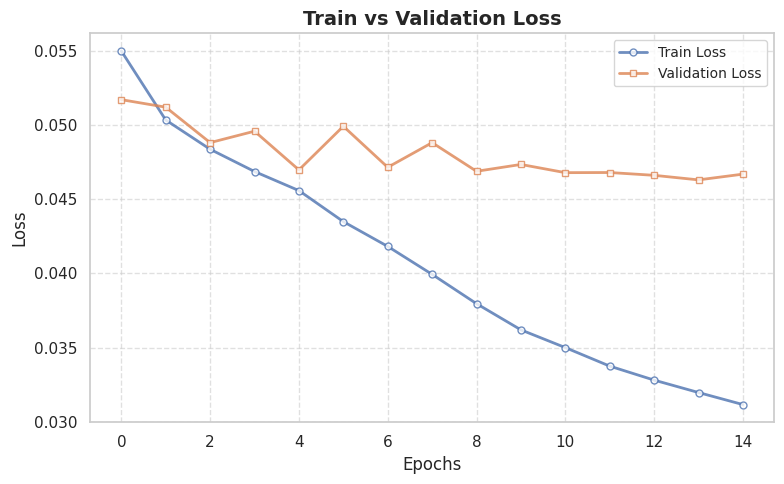

Epoch 16/40, Train Loss: 0.030554, Val Loss: 0.046214
New best model saved with val_loss: 0.046214


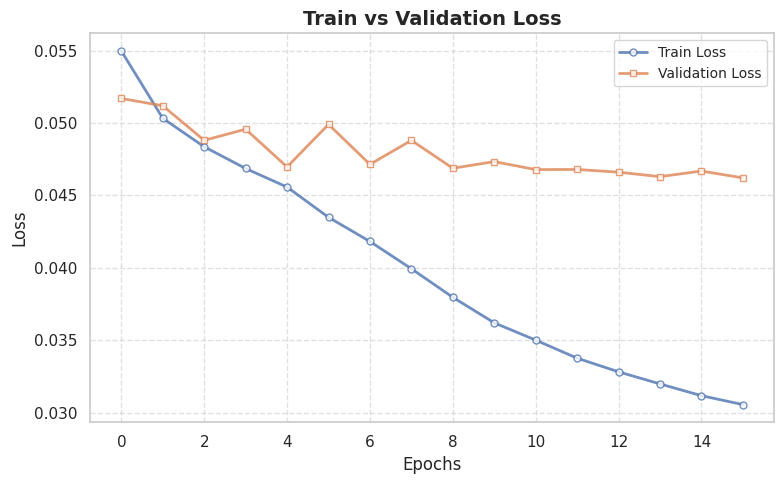

Epoch 17/40, Train Loss: 0.029835, Val Loss: 0.046180
New best model saved with val_loss: 0.046180


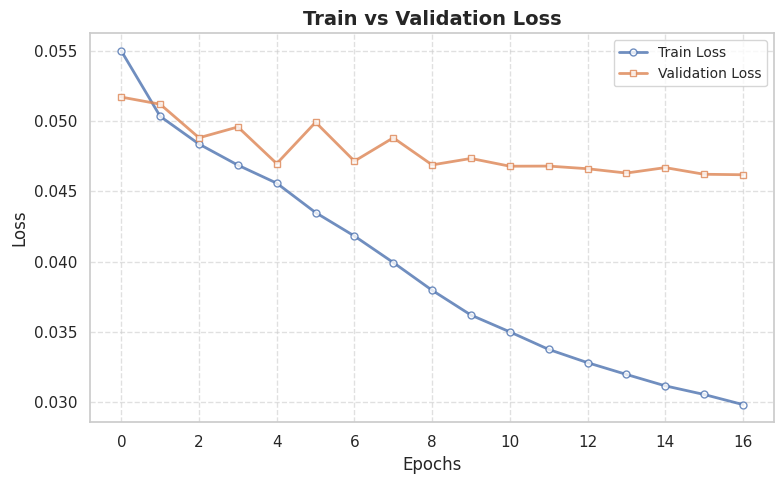

Epoch 18/40, Train Loss: 0.029293, Val Loss: 0.046499


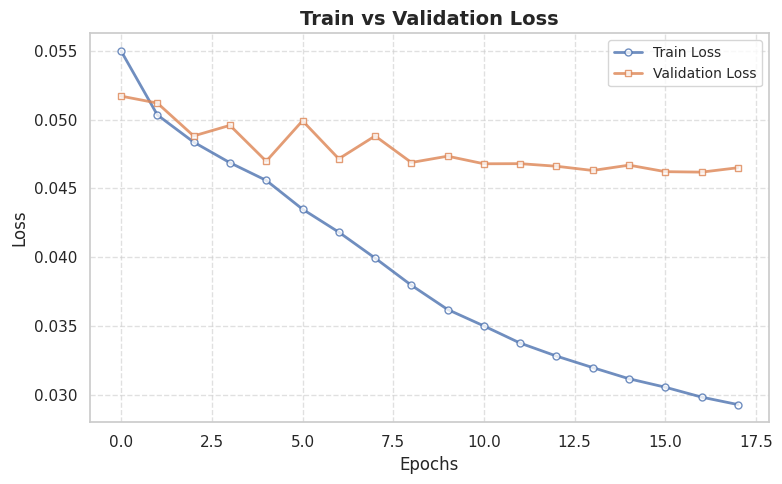

Epoch 19/40, Train Loss: 0.028643, Val Loss: 0.046451


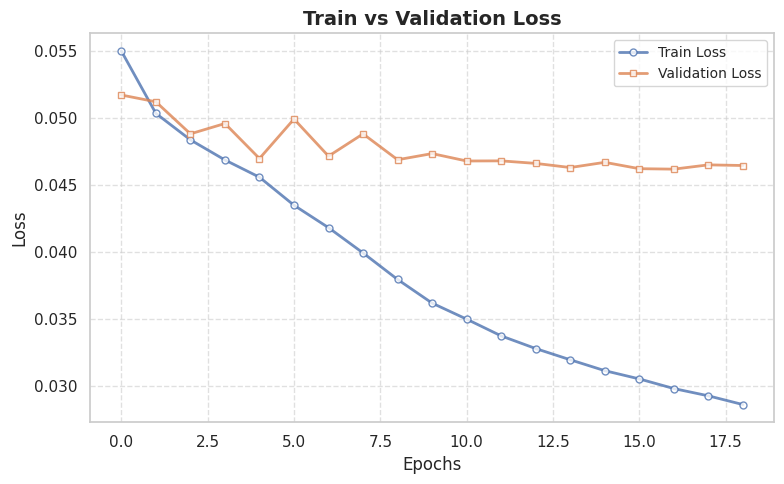

Epoch 20/40, Train Loss: 0.028143, Val Loss: 0.046022
New best model saved with val_loss: 0.046022


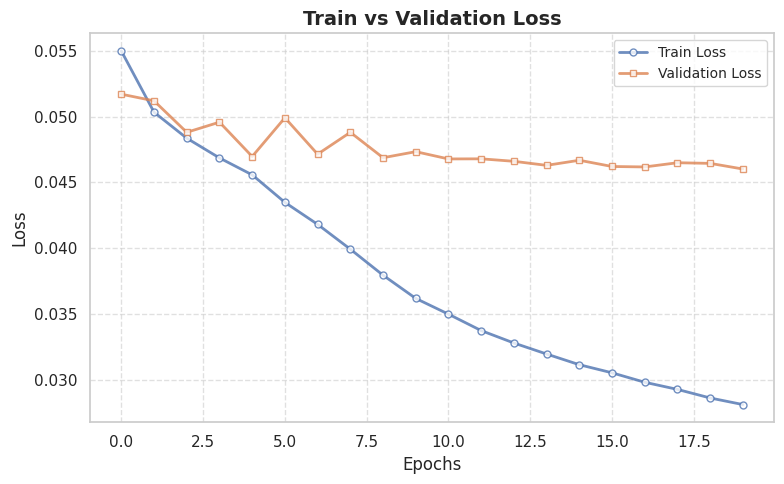

Epoch 21/40, Train Loss: 0.027586, Val Loss: 0.046213


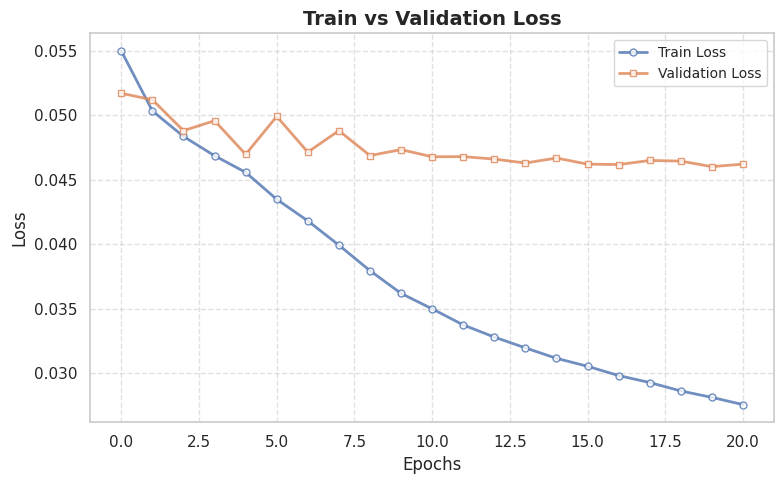

Epoch 22/40, Train Loss: 0.027020, Val Loss: 0.046653


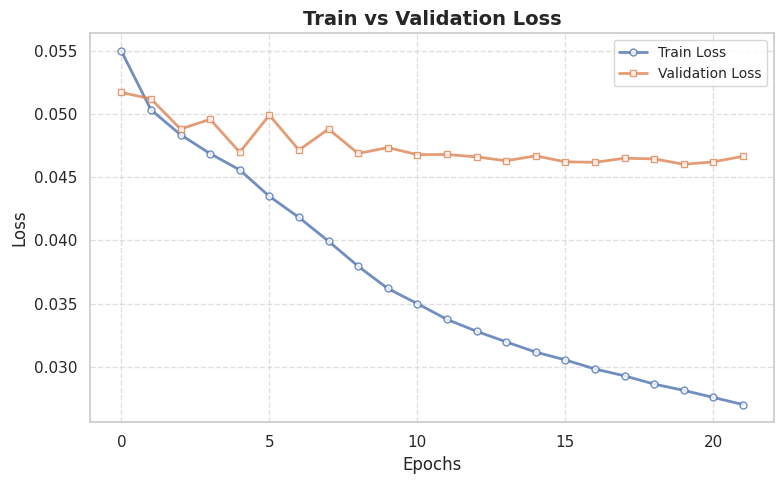

Epoch 23/40, Train Loss: 0.026543, Val Loss: 0.046507


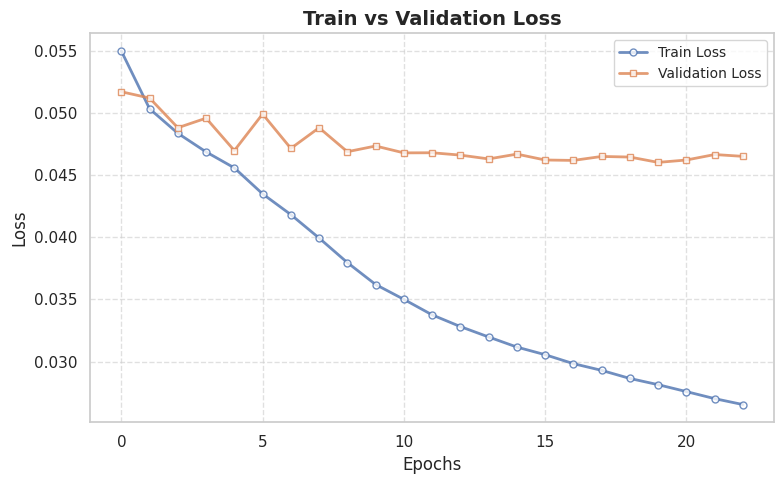

Epoch 24/40, Train Loss: 0.026032, Val Loss: 0.046128
Early stopping triggered


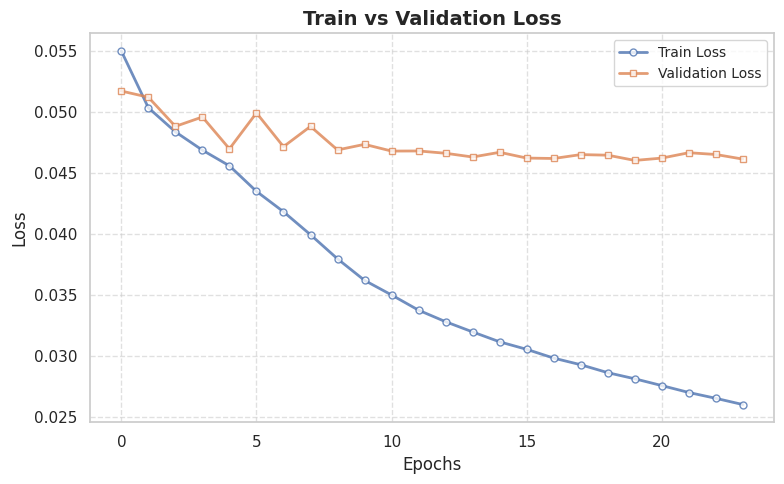

In [19]:
if __name__ == "__main__":
    train_model()